MIE 1613 A2
- Name: William Hazen
- Student ID: 1009231225
- Department: MIE
- Program: M.Eng.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)

In [2]:
import SimClasses, SimRNG, SimFunctions

# 3 (Down-and-out call option)

### **Q3 Logic:**

To change the Asian Option Evaluation example to a down-and-out call option (another variation of European options) being a barrier option,  is modified as follows. We start with defining a function down_and_out with B = Barrier as an input. From here we added a condition in the steps loop where if min(X(t)) ranging from the 0 to T is less than or equal to B then there is a *worthless* instance is set to 0 where it is mutipled to the *Value* instance - to note *Value* was modified to take X instead of the average of X as this is a European option. The *worthless* instance is initalized to be equal to 1, which indicated that if the min(X(t))>B then the option contains its value, but if the asset falls below B before the option matures then *Value* is worthless.

In [390]:
# Down-and-out call option
def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    hw = hw
    m = m
    return m, [m-hw, m+hw]


def down_and_out(Barrier):
    B = Barrier

    Maturity = 1.0
    InterestRate = 0.05
    Sigma = 0.3
    InitialValue = 50.0
    StrikePrice = 55.0
    Steps = 64 #64 steps
    Interval = Maturity / Steps
    Sigma2 = Sigma * Sigma / 2

    np.random.seed(1)
    Replications = 40000 #40k replications

    Interval = Maturity / Steps

    ValueList = []  # List to keep the option value for each sample path

        

    for i in range(0, Replications):
        X = InitialValue
        worthless = 1 # initalize barrier instance
        X_list = []
        values = []
        times = []
 
        for j in range(0, Steps):
            Z = np.random.standard_normal(1)
            X_list.append(X)
            
            X = X * np.exp((InterestRate - Sigma2) * Interval + Sigma * np.sqrt(Interval) * Z)
            
            if min(X_list) <= B: # if the min_value of X(t) between 0&T is less than or equal to B then barrier instance = 0
                worthless = 0
            
            values.append(X)
            times.append(j)
                
        Value = worthless*(np.exp(-InterestRate * Maturity)* max(X - StrikePrice, 0)) #change Sum/N to X and mulitplied output by barrier instance being either (0 or 1)
        ValueList.append(Value)

        if i % 40000 == 0:
            plt.plot(times, values)
            plt.rcParams['figure.figsize'] = (10, 5)
            plt.rcParams.update({'font.size': 18})
            plt.xlabel('t')
            plt.ylabel('X(t)')
            plt.title("X(t) vs t (Replication {} & B = {})".format(i, B))
            plt.show()
    
        # plot a histogram of the option values across 1000 replications
    plt.hist(np.array(ValueList).astype(float), bins=25)
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.rcParams['figure.figsize'] = (10, 5)
    plt.rcParams.update({'font.size': 18})
    plt.show()

    print("For Barrier = {}".format(B))
    print("Mean and CI:", CI_95(ValueList))
    print()

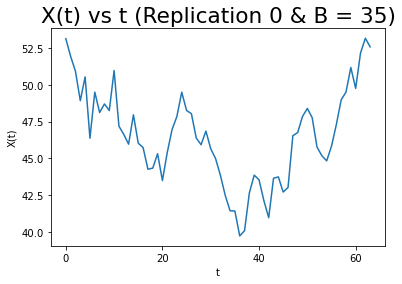

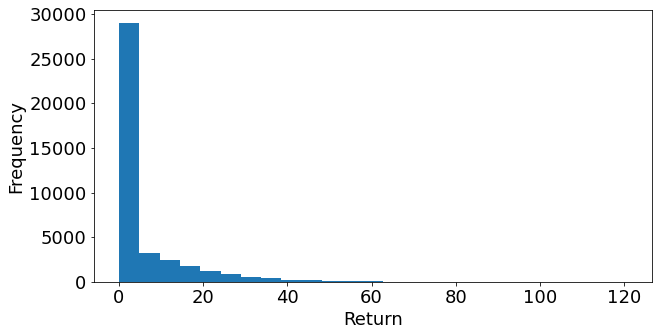

For Barrier = 35
Mean and CI: (array([5.01634625]), [array([4.92040633]), array([5.11228618])])



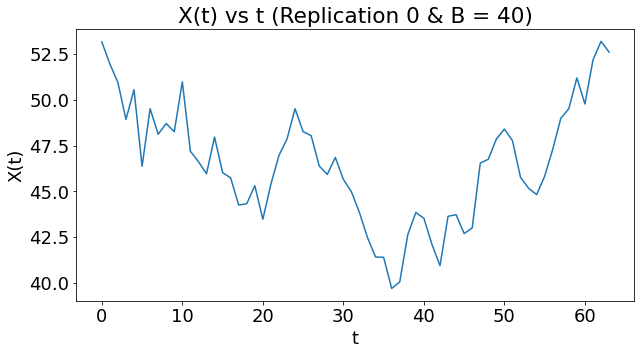

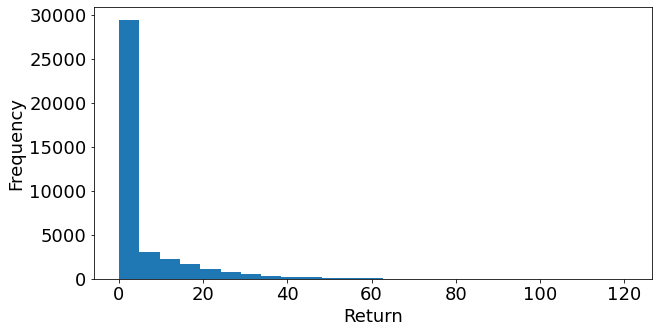

For Barrier = 40
Mean and CI: (array([4.85912244]), [array([4.76349962]), array([4.95474527])])



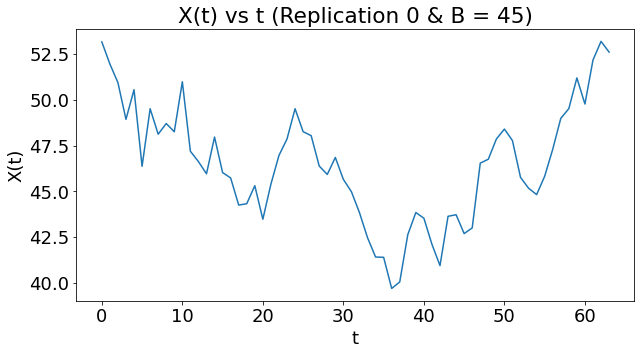

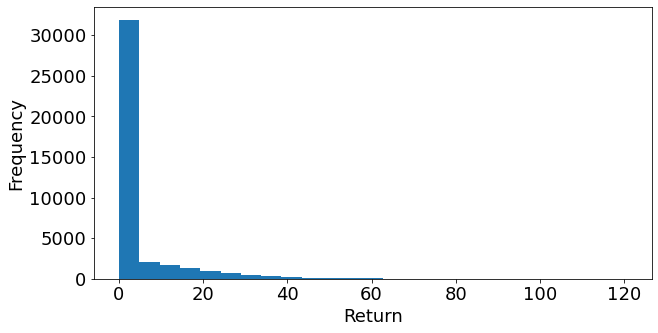

For Barrier = 45
Mean and CI: (array([3.93577346]), [array([3.84442589]), array([4.02712103])])



In [391]:
b_list = [35, 40, 45]
for b in b_list:
    down_and_out(Barrier=b)

### **Q3 Results:**

For n = 40k replications and 65 steps the 95% confidence intervals for B = 35, 40, 45 are the following.

For Barrier = 35
- Mean and CI: (([5.01634625]), [([4.92040633]), ([5.11228618])])

For Barrier = 40
- Mean and CI: (([4.85912244]), [([4.76349962]), ([4.95474527])])

For Barrier = 45
- Mean and CI: (([3.93577346]), [([3.84442589]), ([4.02712103])])

The results show that X(t) is indeed a Geometric Brownian Motion (GBM) but as the barrier value increases (B) the expected value of the option decreases. 

# 4

### **Q4 Logic:**

To modify the MG1 code to MGS was the following. Modifications were made to *Arrival* and *EndOfService* functions as MG1 was a special case where the server could either be 0 or 1 such that many of the if statements (for example Queue.NumQueue() > 0) only works because the Queue value is binary such that the make adjustments for MGs, I had to account for *s* (being Queue.NumQueue() >= s). Moreover, DepartingCustomer can sometimes be empty so to account for it, the recored time will only happen if the class contatins some value.

In [354]:
"""
MG1 Code
"""
def MGS(s):
    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Server)

    Server.SetUnits(s)  # changed SetUnits(1) to SetUnits(s)
    MeanTBA = 1.0
    MeanST = 0.8*s      # multiplyed service time by s
    Phases = 3
    RunLength = 55000.0
    WarmUp = 5000.0

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []

    def Arrival():
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Customer = SimClasses.Entity()
        Queue.Add(Customer)
                
        if Server.Busy < s: 
            if Server.Busy >= 0:   # modified arrival function as the simulation can have more than 1 server 
                                    # meaning Server.Busy can take on more values than 0 or 1
                                    # the model will seize 1 server if there is available spots in server
                Server.Seize(1)
                SimFunctions.Schedule(Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))            
        else:
            pass
   
    def EndOfService():
        DepartingCustomer = Queue.Remove()
        if DepartingCustomer is not None:
            Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)  
                                                        # modified EndOfService function to account for more than one server
                                                        # We only record a time if there is a DepartingCustomer
        else:
            pass
        
        if Queue.NumQueue() >= s:
            SimFunctions.Schedule(Calendar, "EndOfService",SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Server.Free(1)

    for reps in range(0, 10, 1):

        SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar, "EndSimulation", RunLength)
        SimFunctions.Schedule(Calendar, "ClearIt", WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats, TheDTStats)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Server.Mean())
   
   
    print("For s =", s)
    print("Estimated Expected Average wait:", np.mean(AllWaitMean))
    print("Estimated Expected Average queue-length:", np.mean(AllQueueMean))
    print("Estimated Expected Average utilization:", np.mean(AllServerMean))
    print("Estimated Expected Queue Number utilization:", np.mean(AllQueueNum))
    
    # convert the output to a dataframe and write to a .csv file
    q4_output = {"AllWaitMean": AllWaitMean, "AllQueueMean": AllQueueMean,
            "AllQueueNum": AllQueueNum, "AllServerMean": AllServerMean}
    return pd.DataFrame(q4_output)

### 4(a) Report the estimated expected number of customers in the system (including customers in the queue and service), expected system time, and expected number of busy servers in each case

In [355]:
s1_q4_output = MGS(1)
s1_q4_output.describe()[1:2]


For s = 1
Estimated Expected Average wait: 2.955728254108055
Estimated Expected Average queue-length: 2.953284036475683
Estimated Expected Average utilization: 0.7991281862018872
Estimated Expected Queue Number utilization: 2.6


,AllWaitMean,AllQueueMean,AllQueueNum,AllServerMean
mean,2.955728,2.953284,2.6,0.799128


In [356]:
s2_q4_output = MGS(2)
s2_q4_output.describe()[1:2]

For s = 2
Estimated Expected Average wait: 3.5528292355331788
Estimated Expected Average queue-length: 3.558003273851091
Estimated Expected Average utilization: 1.6033973648182993
Estimated Expected Queue Number utilization: 3.6


,AllWaitMean,AllQueueMean,AllQueueNum,AllServerMean
mean,3.552829,3.558003,3.6,1.603397


In [357]:
s3_q4_output = MGS(3)
s3_q4_output.describe()[1:2]

For s = 3
Estimated Expected Average wait: 4.127334319059126
Estimated Expected Average queue-length: 4.1202979864996765
Estimated Expected Average utilization: 2.3980343482680206
Estimated Expected Queue Number utilization: 4.2


,AllWaitMean,AllQueueMean,AllQueueNum,AllServerMean
mean,4.127334,4.120298,4.2,2.398034


### 4(b)  Compare the results and state clearly what you observe. What you’re doing is comparing queues with the same service capacity, but with 1 fast server as compared to 2 or more slow servers

### **Q4 Results:**

As we increase the number of servers the expected values wait times and queue lengths actually increases. The average service time tau = 0.8*s impacts the wait time significatly as 1 fast server seems to outperform 2 or more slower severs. Thus we can say the what determines the wait times is the service rate.

# 5

### **Q5 Logic:**

The following code for Q5 was a modifed version of MG1 where the simulation became MG1C where C is some Retrial threshold. To account for the retrail, a function was created that was similar to the arrival function however, if the number of customers ahead (including the one being servered) is greater than c then the customer who just arrival will arrive again after an exponentially distributed amount of time with mean MeanTR. This function is also schedule in the calender in the Arrival function. To assure that the retrial customer does not affect the first time arrival process, the Next.Event = EventType = "Retrail" is only stated in the while loop. To check if the arrival rate needs to be small than the service rate for the system to reach a steady-state created a fuction where we can input values to test. To note, the Runtime and Warmup values were modified to speed up the process.

In [375]:

def MG1c(c, MeanTR, MeanTBA, MeanST):

    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Server)

    Server.SetUnits(1)

    Phases = 3
    RunLength = 550
    WarmUp = 50

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []
    
    print("c = {}, MeanTR = {}, MeanTBA = {}, MeanST = {}, ServiceRate = {}".format(c, MeanTR, MeanTBA, MeanST, 1/MeanST))

    def Arrival():
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Customer = SimClasses.Entity()
        
        num_customers = Queue.NumQueue() + 1 # number of customers in queue and servered
        #print("DOG ",num_customers)
        if c < num_customers: #if c < number of customer ahead of them then the customer we retry with exponential time
            SimFunctions.Schedule(Calendar, "Retrial", SimRNG.Expon(MeanTR, 5))

        
        Queue.Add(Customer)

        if Server.Busy == 0:
            Server.Seize(1)
            SimFunctions.Schedule(Calendar, "EndOfService",SimRNG.Erlang(Phases, MeanST, 2))

    def Retrial(): # retrail function
        Customer = SimClasses.Entity()
        num_customers = Queue.NumQueue() + 1 # number of people in the system ahead of customer
        #print("CAT ",num_customer_queue)
        if c < num_customers: # account of the same process where if there is still more customers ahead than the will arrival again
            SimFunctions.Schedule(Calendar, "Retrial", SimRNG.Expon(MeanTR, 5))
        else:
            Queue.Add(Customer)
            if Server.Busy == 0:
                Server.Seize(1)
                SimFunctions.Schedule(Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))
            
    
    def EndOfService():
        DepartingCustomer = Queue.Remove()
        Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
        
        if Queue.NumQueue() > 0:
            SimFunctions.Schedule(Calendar, "EndOfService",
                                SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Server.Free(1)
                
    for reps in range(0, 10, 1):

        SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar, "EndSimulation", RunLength)
        SimFunctions.Schedule(Calendar, "ClearIt", WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "Retrial":  # added Retrial event type
                Retrial()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats, TheDTStats)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Server.Mean())

    q5_output = {"Estimated Expected Average wait:": AllWaitMean, "Estimated Expected Average queue-length:": AllQueueMean,
                 "Estimated Expected Queue Number:": AllQueueNum, "Estimated Expected Average utilization:": AllServerMean}
    return pd.DataFrame(q5_output)
    


### **HINT**: The existence of retrial customers should not affect the arrival process for first-time arrivals.

In [377]:
q5_output = MG1c(c=3, MeanTR=1.0, MeanTBA=1.0, MeanST=0.8)
q5_output.describe()[1:2]


c = 3, MeanTR = 1.0, MeanTBA = 1.0, MeanST = 0.8, ServiceRate = 1.25


,Estimated Expected Average wait:,Estimated Expected Average queue-length:,Estimated Expected Queue Number:,Estimated Expected Average utilization:
mean,4.673973,5.808993,7.4,0.998998


In [378]:
q5_output = MG1c(c=3, MeanTR=3.0, MeanTBA=1.0, MeanST=0.8)
q5_output.describe()[1:2]


c = 3, MeanTR = 3.0, MeanTBA = 1.0, MeanST = 0.8, ServiceRate = 1.25


,Estimated Expected Average wait:,Estimated Expected Average queue-length:,Estimated Expected Queue Number:,Estimated Expected Average utilization:
mean,4.674116,5.818235,5.2,0.999345


In [386]:
q5_output = MG1c(c=6, MeanTR=30, MeanTBA=1.0, MeanST=2)
q5_output.describe()[1:2]


c = 6, MeanTR = 30, MeanTBA = 1.0, MeanST = 2, ServiceRate = 0.5


,Estimated Expected Average wait:,Estimated Expected Average queue-length:,Estimated Expected Queue Number:,Estimated Expected Average utilization:
mean,147.523666,150.745094,281.8,1.0


In [382]:
q5_output = MG1c(c=7, MeanTR=2, MeanTBA=2.0, MeanST=0.5)
q5_output.describe()[1:2]


c = 7, MeanTR = 2, MeanTBA = 2.0, MeanST = 0.5, ServiceRate = 2.0


,Estimated Expected Average wait:,Estimated Expected Average queue-length:,Estimated Expected Queue Number:,Estimated Expected Average utilization:
mean,0.618943,0.308599,0.4,0.245662


### **Q5 Results:**

**Do we need the arrival rate λ to be smaller than service rate 1/τ for the system to reach steady-state? Explain your answer using numerical evidence from the simulation model.**

No, we do not need the arrival rate to be smaller than the service rate for the systemt to reach a steady-state due to the customer always retrying until they get by the threshold so the queue length could grow exponentially. Numerically the wait time are less when the arrival rate is less than the service rate, however the system over time.

# 6

### **Q6 Logic:**

The scheduling of long-term care home staff should follow an MGs simulation with the appropiate modifications. Using similar code from Q4, the EndOfSimulation was replaced with a count such that the simulation will end if all the staff has been treated. The staff arrives within a 30min uniformally distributed interval and the events for all 170 staff are scheduled at the beginning at each replication. The MeanTBA is set to 30 and MeanST is the service rate (test time) of 15min.     

### 6(a) Provide a 95% Confidence Interval for the expected average waiting time (excluding the test time) of staff when there are 10 parallel servers (testing stations) available. Assume that staff wait in a single First-Come, First-Serverd queue before being tested. Use 100 replications.

In [368]:

def Staff_Server(s):
    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Server)

    Server.SetUnits(s)  # changed SetUnits(1) to SetUnits(s)
    MeanTBA = 30
    MeanST = 15      # multiplyed service time by s
    Phases = 4
    #RunLength = 55000.0
    staff = 170

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []

    def CI_95(data):    # define 95% confidence interval function
        a = np.array(data)
        n = len(a)
        m = np.mean(a)
        sd = np.std(a, ddof=1)
        hw = 1.96*sd / np.sqrt(n)
        return m, m-hw, m+hw

    def Arrival():
        #SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Customer = SimClasses.Entity()
        Queue.Add(Customer)

        if Server.Busy < s:
            if Server.Busy >= 0:   # modified arrival function as the simulation can have more than 1 server
                # meaning Server.Busy can take on more values than 0 or 1
                # the model will seize 1 server if there is available spots in server
                Server.Seize(1)
                SimFunctions.Schedule(
                    Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))
        else:
            pass

    def EndOfService(count):
        count += 1
        DepartingCustomer = Queue.Remove()
        if DepartingCustomer is not None:
            Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
                # modified EndOfService function to account for more than one server
                # We only record a time if there is a DepartingCustomer
        else:
            pass
        if Queue.NumQueue() >= s:
            SimFunctions.Schedule(Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Server.Free(1)
        return count

    for reps in range(0, 100, 1):
        count = 1 #initalize count
        SimFunctions.SimFunctionsInit(
            Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        for _ in range(staff): #schedule the staff on the calendar for each rep
            SimFunctions.Schedule(Calendar, "Arrival",
                                  SimRNG.Uniform(0, MeanTBA, 5))
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            count = EndOfService(count)

        while count < staff: #if count >= staff then End of Simulation
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                count = EndOfService(count)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Server.Mean())

    output = {"AllWaitMean": AllWaitMean, "CI_95 (-)": CI_95(AllWaitMean)[1], "CI_95 (+)": CI_95(AllWaitMean)[2], "AllQueueMean": np.mean(AllQueueMean), "AllServerMean:": np.mean(AllServerMean)}
    return pd.DataFrame(output)


In [369]:
pd_out = Staff_Server(s=10)
pd_out.describe()[1:2]

,AllWaitMean,CI_95 (-),CI_95 (+),AllQueueMean,AllServerMean:
mean,118.67453,117.599635,119.749425,76.94233,9.646673


### 6(b) Approximately how many servers are required to keep the average waiting time below 15 minutes?

In [370]:
s_list = [i for i in range(10,90)]
val=[]
wait = 0
final_s = 0
for s in s_list:
    pd_out = Staff_Server(s=s)
    wait = pd_out.describe().iloc[1][0]
    val.append(wait)
    if wait < 15:
        print(s)
        final_s = s


84
85
86
87
88
89


Text(0.5, 1.0, 'Number of Servers per average wait times')

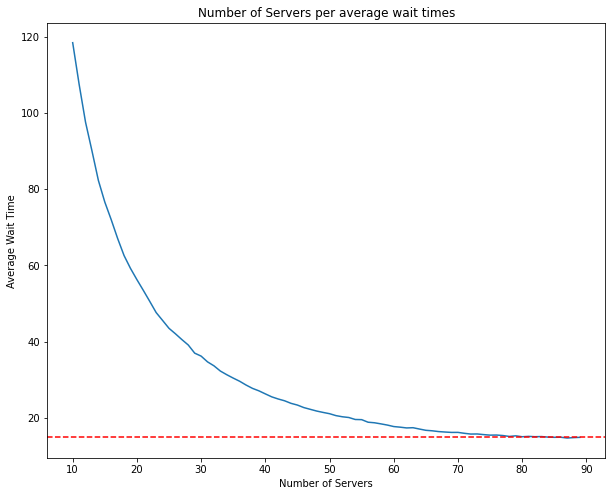

In [371]:
plt.figure(figsize=(10,8))
plt.plot(s_list, val)
#plt.xticks([i for i in range(40, 90)])
plt.ylabel("Average Wait Time")
plt.xlabel("Number of Servers")
plt.axhline(y=15, color='r', linestyle='--')
plt.title("Number of Servers per average wait times")

#### HINT: You may want to schedule the arrival events for all 170 staff to the calendar at the beginning of each replication.

### **Q6b Results:**

The number of servers need to keep the expected wait time below 15min is around 84. The plot shows an exponential decay behaviour such that as we increase the number of servers we should expected a decay in the wait time.

In [ ]:
%%shell
jupyter nbconvert --to html /content/MIE1613_A2.ipynb